In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import statsmodels.api as sm


---

In [2]:
precios =  pd.read_csv("../data/sp500_precios.csv", index_col=0, parse_dates=True)
precios.head(5)

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,63.381710,31.963160,37.893341,70.646538,63.908173,26.190001,131.077469,224.570007,78.138260,35.836353,...,41.850040,53.962513,35.926987,62.568439,83.576164,95.619514,156.240005,35.226196,81.659958,230.557449
2019-01-03,61.046745,29.581663,34.118874,68.318840,60.892082,25.780001,126.602242,215.699997,73.418312,35.678822,...,41.685143,53.133984,35.945953,60.423553,81.473938,93.889969,146.880005,35.031338,78.837448,225.055740
2019-01-04,63.159786,31.530161,35.575378,70.519852,62.630009,26.389999,131.524994,226.190002,75.200783,36.501442,...,42.093063,55.093021,36.988953,62.972939,83.594421,97.096619,152.970001,36.107277,81.930641,232.594147
2019-01-07,64.500923,32.425674,35.496204,71.549126,63.567928,26.330000,131.981812,229.259995,75.673691,36.685211,...,41.910801,55.379513,37.652691,62.041607,83.503029,97.134010,155.289993,36.251289,82.423607,234.428024
2019-01-08,65.446503,31.904114,36.172874,71.881653,62.804718,26.430000,135.319580,232.679993,77.519836,37.367813,...,42.396820,55.782177,37.396687,62.624863,83.338516,94.955734,156.330002,36.581703,83.651207,236.630554


In [3]:
precios = precios.iloc[:,:-1]

In [4]:
retornos = np.log(precios).diff().dropna()
matriz_cov = retornos.cov().to_numpy()
retornos_esperados = retornos.mean().to_numpy() 
num_act = len(retornos.columns)

In [8]:
#Variables de decisión
pesos = cp.Variable(num_act)

#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

#Función Objetivo
riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

ret = retornos_esperados.T @ pesos # Retorno esperado de la cartera

#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

#Guardamos los valores de la rentabilidad y riesgo de la cartera de mínimo riesgo
min_riesgo = np.array([riesgo.value, ret.value])


In [9]:
riesgos_lst = np.linspace(min_riesgo[0], np.diag(matriz_cov).max(), num=500)

In [10]:
def optimizar_cartera(risk, num_act, retornos_esperados, matriz_cov):
    # Variables de decisión
    pesos = cp.Variable(num_act)

    # Función objetivo
    rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

    # Restricciones
    riesgo = cp.quad_form(pesos, matriz_cov)
    constraints = [pesos >= 0, cp.sum(pesos) == 1, riesgo <= risk]

    # Resolver problema
    prob = cp.Problem(rentabilidad, constraints)
    resultado = prob.solve(solver=cp.GUROBI)

    return rentabilidad.value, pesos.value



# Paralelización con joblib
resultados = Parallel(n_jobs=-1)(delayed(optimizar_cartera)(risk, num_act, retornos_esperados, matriz_cov) for risk in tqdm(riesgos_lst, desc="Optimizando Carteras"))

# Separar los resultados en listas de retornos y pesos
retornos_lst, pesos_lst = zip(*resultados)

Optimizando Carteras:   0%|          | 0/500 [00:00<?, ?it/s]

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es
Set parameter

In [14]:
frontera_eficiente_sp500 = pd.read_csv("../data/frontera_eficiente_sp500.csv", index_col=0)

In [45]:
pesos_frontera_efi_df = pd.DataFrame(pesos_lst, columns=retornos.columns)

In [49]:
pesos_orden = pesos_frontera_efi_df.sum()
pesos_orden


A       0.000014
AAL     0.000004
AAPL    0.000109
ABBV    0.397035
ABT     0.000013
          ...   
YUM     0.000012
ZBH     0.000009
ZBRA    0.000009
ZION    0.000009
ZTS     0.000017
Length: 489, dtype: float64

In [51]:
ranks = pesos_orden.argsort().argsort()

# Invertir el rango para que el mayor valor tenga el rango 1
pesos_ranking = len(pesos_orden) - ranks

# Si quieres que los rangos comiencen desde 1 en lugar de 0
pesos_ranking += 1



A       216
AAL     486
AAPL     52
ABBV     18
ABT     249
       ... 
YUM     263
ZBH     386
ZBRA    403
ZION    415
ZTS     156
Length: 489, dtype: int64

In [58]:
type(retornos.mean())

pandas.core.series.Series

In [61]:
ranks = retornos.mean().argsort().argsort()

# Invertir el rango para que el mayor valor tenga el rango 1
retornos_ranking = len(retornos.mean()) - ranks

# Si quieres que los rangos comiencen desde 1 en lugar de 0
retornos_ranking += 1

retornos_ranking

A       163
AAL     487
AAPL     23
ABBV    162
ABT     285
       ... 
YUM     316
ZBH     404
ZBRA    272
ZION    409
ZTS     127
Length: 489, dtype: int64

In [63]:
ranks = retornos.std().argsort().argsort()

# Invertir el rango para que el mayor valor tenga el rango 1
vol_ranking = len(retornos.mean()) - ranks

# Si quieres que los rangos comiencen desde 1 en lugar de 0
vol_ranking += 1

vol_ranking

A       355
AAL      18
AAPL    267
ABBV    452
ABT     435
       ... 
YUM     453
ZBH     300
ZBRA    106
ZION     64
ZTS     389
Length: 489, dtype: int64

In [64]:
sharpe = retornos.mean() / retornos.std()

ranks = sharpe.argsort().argsort()

# Invertir el rango para que el mayor valor tenga el rango 1
sharpe_ranking = len(retornos.mean()) - ranks

# Si quieres que los rangos comiencen desde 1 en lugar de 0
sharpe_ranking += 1

sharpe_ranking

A       136
AAL     483
AAPL      9
ABBV     94
ABT     214
       ... 
YUM     254
ZBH     391
ZBRA    317
ZION    425
ZTS      90
Length: 489, dtype: int64

In [75]:
covars = np.array(matriz_cov).sum(axis=1)

ranks = covars.argsort().argsort()

# Invertir el rango para que el mayor valor tenga el rango 1
covars_ranking = len(retornos.mean()) - ranks

# Si quieres que los rangos comiencen desde 1 en lugar de 0
covars_ranking += 1

covars_ranking

array([305,  32, 263, 458, 409, 199, 255, 245, 142, 343, 264, 130, 429,
       455, 132, 194,  56, 312, 348, 453,  70,  38, 325, 222,  43, 299,
        90, 211, 457,  28, 368, 367, 247, 190, 392, 339,   6, 316, 216,
        30, 284, 431, 286, 135, 224, 422, 177,  69, 402,  29, 101, 383,
       439,  26, 166, 465, 124, 320, 427, 397, 201, 169,  99,  13, 151,
       469, 374, 337, 300, 174,  66, 129,  58, 482, 384, 243, 307, 444,
        84, 388,   4,  92, 228, 173,  76, 182,  21, 483, 448, 400, 291,
       207, 474, 490,  24, 357, 381, 336, 274, 452, 333, 251,  27, 322,
       106, 420, 451, 488, 268, 308, 172, 242, 335, 281, 229, 184, 185,
       398, 217, 419, 179,   2, 425,  45, 149, 225,  10, 470, 442, 143,
       394, 230, 406, 399, 167, 476,  65, 341, 428, 413,  16, 290, 466,
       391, 213, 468, 273, 315, 349, 218, 304, 115, 155,  31, 121, 112,
       393, 296, 301, 426, 278, 164, 363, 114, 385, 302, 318, 382,  50,
       411,  93,  34, 330,  19, 329, 205, 396, 319, 239, 125, 22

In [76]:
ranking_df = pd.DataFrame({"Retornos": retornos_ranking, "Volatilidad": vol_ranking, "Sharpe": sharpe_ranking, "Covarianza": covars_ranking, "Pesos": pesos_ranking}, index=retornos.columns)
ranking_df['Media'] = ranking_df.iloc[:, 0:4].mean(axis=1)

In [89]:
ranking_df

,Retornos,Volatilidad,Sharpe,Covarianza,Pesos,Media
A,163,355,136,305,216,239.75
AAL,487,18,483,32,486,255.00
AAPL,23,267,9,263,52,140.50
ABBV,162,452,94,458,18,291.50
ABT,285,435,214,409,249,335.75
...,...,...,...,...,...,...
YUM,316,453,254,375,263,349.50
ZBH,404,300,391,289,386,346.00
ZBRA,272,106,317,117,403,203.00
ZION,409,64,425,79,415,244.25


In [88]:
X = ranking_df.loc[:, ['Retornos', 'Volatilidad', 'Sharpe', 'Covarianza', 'Media']]
y = ranking_df['Pesos']    # Rendimientos del activo
X_sm = sm.add_constant(X)   # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

# Almacenar los resultados
modelo.params

const          129.075564
Retornos         0.352768
Volatilidad      0.069639
Sharpe           0.422926
Covarianza      -0.465091
Media            0.095061
dtype: float64

In [9]:
num_carteras = 100000

#genero pesos aleatorios
rng= np.random.default_rng(seed=4)
pesos = rng.random((num_carteras, num_act))
pesos /= np.sum(pesos, axis=1)[:, None] #normalizo

In [10]:
#calculo retornos y volatilidades
ret_carteras = retornos @ pesos.T

volatilidades = np.sqrt(np.var(ret_carteras)*252)
rentabilidades = 252*np.mean(ret_carteras, axis=0)

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


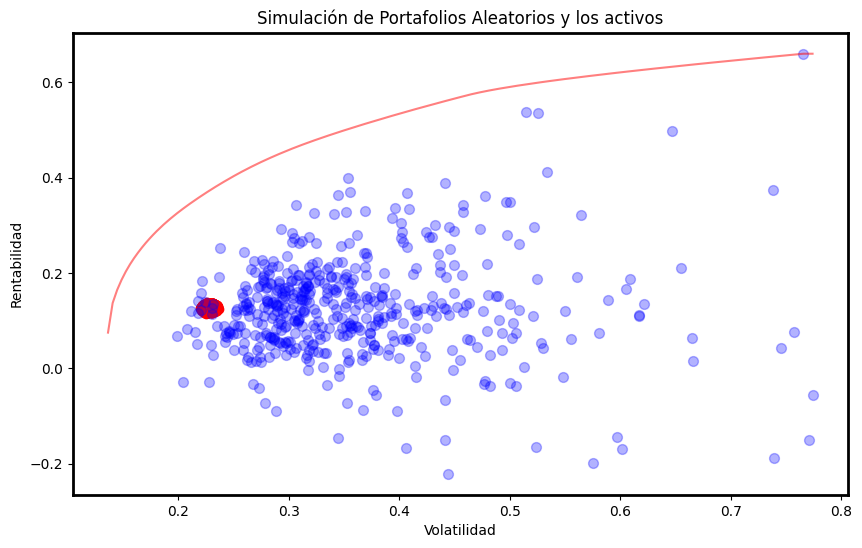

In [11]:
#grafico

plt.figure(figsize=(10, 6))
#plt.scatter(volatilidades, rentabilidades, c=rentabilidades / volatilidades, marker='o', cmap='coolwarm')
plt.scatter(volatilidades, rentabilidades, c='red', marker='o')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.3)

plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='red', label='Frontera Eficiente', alpha=0.5)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario


plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Simulación de Portafolios Aleatorios y los activos')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()

In [12]:
def softmax_con_temperatura_matriz(pesos, temperatura):
    """
    Aplica la función softmax a cada fila de una matriz de pesos con un factor de temperatura.

    Args:
    pesos (array): Matriz de pesos, donde cada fila representa un conjunto de pesos.
    temperatura (float): Factor de temperatura para ajustar la distribución softmax.

    Returns:
    array: Matriz de pesos normalizados mediante softmax con temperatura aplicada por fila.
    """
    # Ajustar los pesos de cada fila según la temperatura
    pesos_ajustados = np.exp(pesos / temperatura)
    
    # Calcular softmax por fila
    suma_filas = np.sum(pesos_ajustados, axis=1)[:, np.newaxis]  # Sumar por filas y mantener las dimensiones
    pesos_softmax = pesos_ajustados / suma_filas
    
    return pesos_softmax

In [13]:
num_carteras = 400000

pesos = rng.random((num_carteras, num_act))

pesos = softmax_con_temperatura_matriz(pesos, 0.0015)

In [14]:
#calculo retornos y volatilidades
ret_carteras = retornos @ pesos.T

volatilidades = np.sqrt(np.var(ret_carteras)*252)
rentabilidades = 252*np.mean(ret_carteras, axis=0)

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


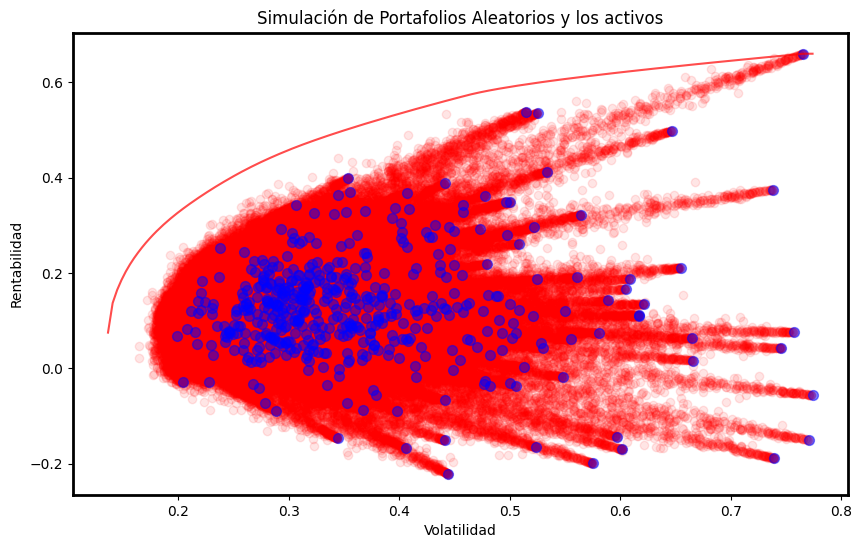

In [15]:
#grafico

plt.figure(figsize=(10, 6))
#plt.scatter(volatilidades, rentabilidades, c=rentabilidades / volatilidades, marker='o', cmap='coolwarm')
plt.scatter(volatilidades, rentabilidades, c='red', marker='o', alpha=0.1)

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.5)

plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='red', label='Frontera Eficiente', alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario


plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Simulación de Portafolios Aleatorios y los activos')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()

In [16]:
resultados_df = pd.DataFrame({'riesgo': riesgos_lst, 'retornos': retornos_lst, 'pesos': pesos_lst})

In [17]:
resultados_df['num_activos'] = resultados_df['pesos'].apply(lambda x: sum(i > 10**-4 for i in x))

Text(0.5, 1.0, 'Número de activos en la frontera eficiente')

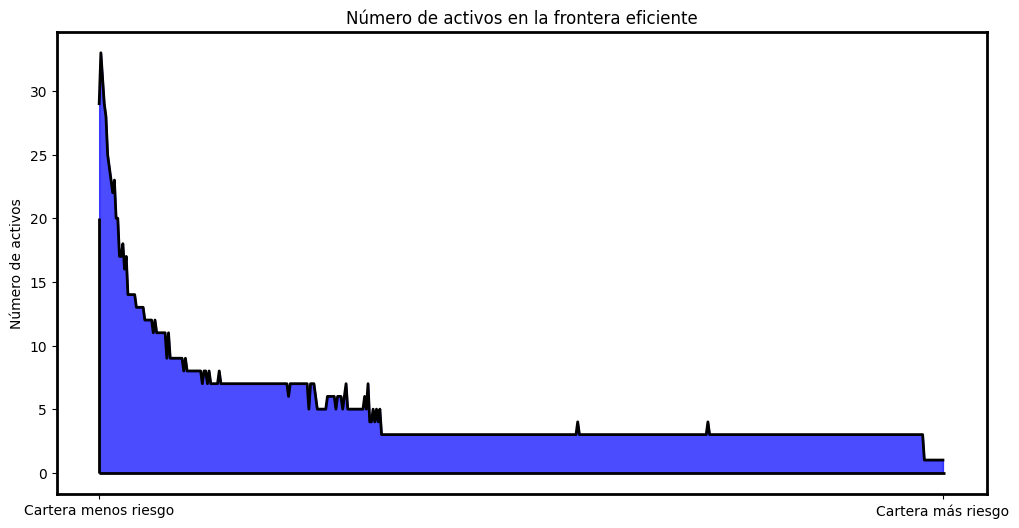

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.fill_between(resultados_df.index, resultados_df['num_activos'], color='blue', alpha=0.7)

plt.plot(resultados_df['num_activos'], color='black', lw=2)


# Personalizando los ticks del eje X
plt.xticks([0, len(resultados_df.index)-1], ['Cartera menos riesgo', 'Cartera más riesgo'], )


# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.hlines(y=0, xmin=0, xmax=500, color='black', lw=2)
plt.vlines(x=0, ymin=0, ymax=20, color='black', lw=2)

plt.ylabel('Número de activos')
plt.title('Número de activos en la frontera eficiente')

In [21]:
sharpe = rentabilidades/volatilidades


1.1305972079683602

In [28]:
threshold = 0.85
sharpe[sharpe > threshold].sum()

14307.77602277727

In [26]:
renta_sharpe = rentabilidades[sharpe > threshold]
vol_sharpe = volatilidades[sharpe > threshold]

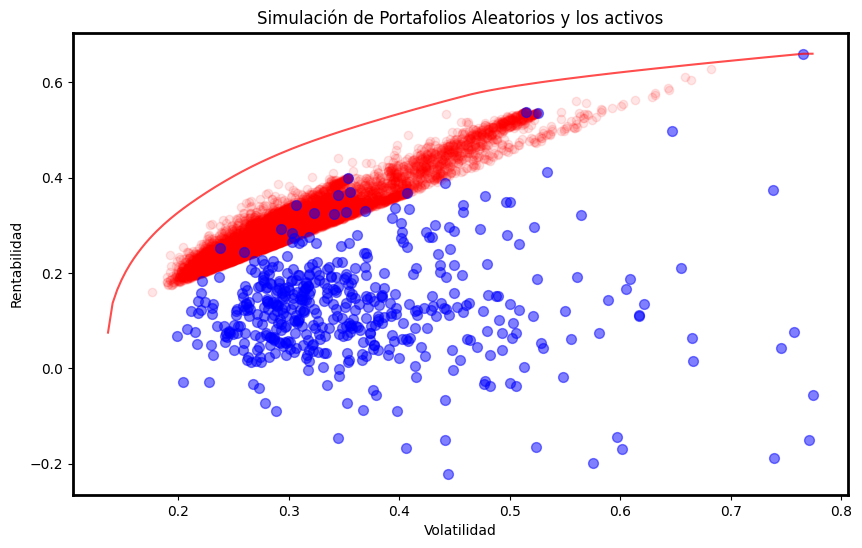

In [27]:
plt.figure(figsize=(10, 6))
#plt.scatter(volatilidades, rentabilidades, c=rentabilidades / volatilidades, marker='o', cmap='coolwarm')
plt.scatter(vol_sharpe, renta_sharpe, c='red', marker='o', alpha=0.1)

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.5)

plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='red', label='Frontera Eficiente', alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario


plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Simulación de Portafolios Aleatorios y los activos')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()

<BarContainer object of 489 artists>

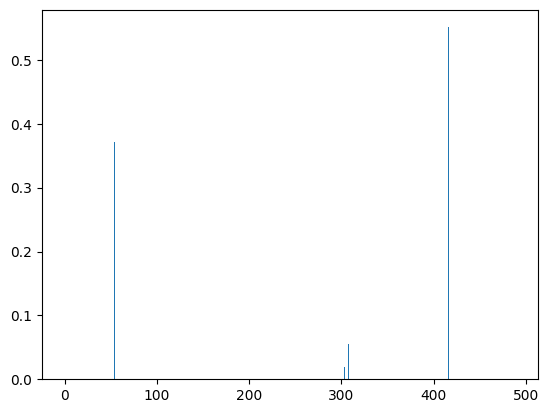

In [71]:
plt.bar(range(len(pesos[10])), pesos[10])

---

In [2]:
import investpy

# Define los parámetros para la descarga de los datos
accion = "AAPL"  # Ejemplo: Apple Inc
pais = "United States"  # Ejemplo: Estados Unidos
desde = "01/01/2020"  # Formato DD/MM/AAAA
hasta = "01/01/2023"  # Formato DD/MM/AAAA

# Descargar datos históricos de precios
datos_historicos = investpy.get_stock_historical_data(stock=accion,
                                                      country=pais,
                                                      from_date=desde,
                                                      to_date=hasta)

print(datos_historicos)


ConnectionError: ERR#0015: error 403, try again later.

In [4]:
investpy.get_stocks_list(country='SPAIN')

['ACS',
 'ABG',
 'A3M',
 'ACX',
 'BBVA',
 'BKT',
 'BME',
 'ANA',
 'CABK',
 'ENAG',
 'FCC',
 'NTGY',
 'SGREN',
 'GRLS',
 'FER',
 'REE',
 'ITX',
 'REP',
 'IBE',
 'IDR',
 'MAP',
 'TEF',
 'TL5',
 'SCYR',
 'SABE',
 'SAN',
 'COL',
 'TRE',
 'OHL',
 'ICAG',
 'EBRO',
 'ELE',
 'AMA',
 'BKIA',
 'DIDA',
 'VTSG',
 'ROVI',
 'GALQ',
 'SLRS',
 'AI',
 'ALNTA',
 'ALB',
 'PRS',
 'MEL',
 'GSJ',
 'NXTE',
 'ADXR',
 'MCM',
 'GCO',
 'SPSL',
 'ENC',
 'CAF',
 'UBS',
 'ISUR',
 'QBT',
 'LGT',
 'IBG',
 'BRIO',
 'ADZ',
 'RLIA',
 'IBES',
 'CBAV',
 'RDM',
 'NEA',
 'CIEA',
 'RTA4',
 'RJFE',
 'EZEN',
 'MDF',
 'ZOT',
 'BDL',
 'MTBA',
 'MVC',
 'NHH',
 'FAE',
 'TUR',
 'PVA',
 'GRLSbn',
 'BIOS',
 'VIS',
 'PSG',
 'ALM',
 'VOC',
 'VID',
 'CCMC',
 'TUBA',
 'REN',
 'FLUI',
 'ENOR',
 'AZK',
 'APAM',
 'SNCE',
 'ECR',
 'CDRE',
 'NATR',
 'APE',
 'AIR',
 'PRIM',
 'OLEO',
 'MTS',
 'ABGek',
 'LBK',
 'EBI',
 'YENT',
 'PETR4',
 'AMXL',
 'BRPO',
 'BRPP',
 'BRKM3',
 'CPLE6',
 'ELTO',
 'ELTB',
 'PETR3',
 'USIO',
 'USIM5',
 'VALO',
 'ALFAA

In [6]:
len(investpy.get_funds_list(country='SPAIN'))

4107

In [7]:
investpy.get_stock_historical_data('ALVG', country='germany', from_date='01/01/2020', to_date='01/01/2021')

ConnectionError: ERR#0015: error 403, try again later.

In [8]:
url = "https://www.investing.com/instruments/HistoricalDataAjax"

In [ ]:
       params = {
            "curr_id": id_,
            "smlID": str(randint(1000000, 99999999)),
            "header": header,
            "st_date": '01/01/2020',
            "end_date": '01/01/2021',
            "interval_sec": interval.capitalize(),
            "sort_col": "date",
            "sort_ord": "DESC",
            "action": "historical_data",
        }

In [ ]:
import requests

req = requests.post(url, headers=head, data=params)